# Image segmentation by an unsupervised learning 

In [1]:
import os
from pyexpat import model
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import statistics

In [2]:
from MyDataset import MyDataset
from MyEval import MyEval
from MyModel import MyModel
from MyResult import MyResult
from MyTrain import MyTrain

## construct dataset for training

In [3]:
dataset_train = MyDataset(path='data', split='train')
print('len(dataset_train)=', len(dataset_train))

len(dataset_train)= 400


## construct dataloader

In [4]:
batch_size = 64 # you can change this value
dataloader = DataLoader(dataset_train, batch_size=batch_size, drop_last=True, shuffle=True)

## plot the dataset

In [5]:
iter_data       = iter(dataloader)
(image, mask)   = next(iter_data)
print(image.shape, mask.shape)
print(image.dtype, mask.dtype)
print(f'image : (min) = {image.min()}, (max) = {image.max()}')
print(f'mask : (min) = {mask.min()}, (max) = {mask.max()}')

torch.Size([64, 1, 32, 32]) torch.Size([64, 1, 32, 32])
torch.float32 torch.float32
image : (min) = 0.0, (max) = 0.9960784316062927
mask : (min) = 0.0, (max) = 0.9960784316062927


## plot images

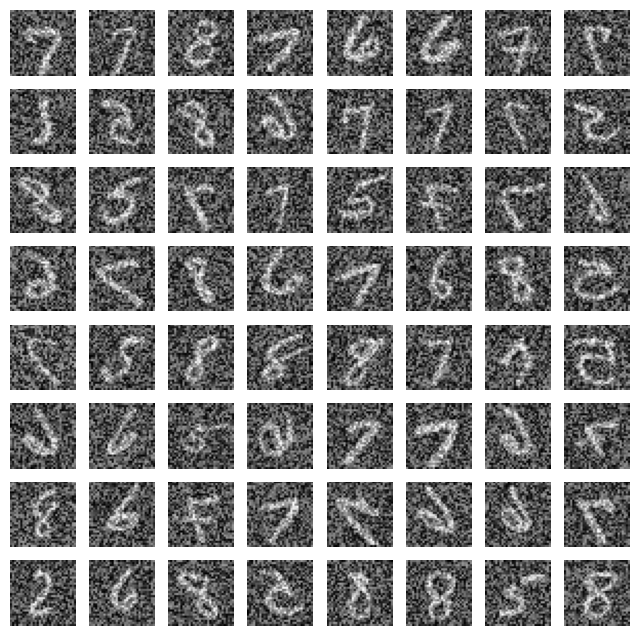

In [6]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        plt.imshow(image[idx].squeeze(0), cmap='gray')
plt.show()

## plot masks

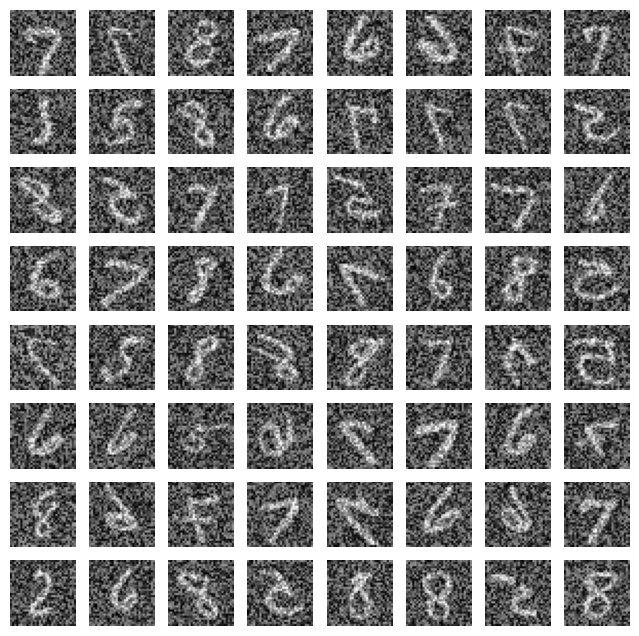

In [7]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        plt.imshow(mask[idx].squeeze(0), cmap='gray')
plt.show()

## construct model

In [8]:
model       = MyModel()
size_model  = model.size()
pred        = model(image)
print(f'image: {image.shape}')
print(f'pred: {pred.shape}')
print('model size =', size_model)
print(f'image (min)={image.min()}, (max)={image.max()}')
print(f'pred (min)={pred.min()}, (max)={pred.max()}')
print(f'mask (min)={mask.min()}, (max)={mask.max()}')

image: torch.Size([64, 1, 32, 32])
pred: torch.Size([64, 1, 32, 32])
model size = 149377
image (min)=0.0, (max)=0.9960784316062927
pred (min)=0.5, (max)=0.991827130317688
mask (min)=0.0, (max)=0.9960784316062927


## train 

In [9]:
print(dataset_train)

In [10]:
trainer = MyTrain(model=model,epochs=30)
trainer.train(dataset=dataset_train)
model = trainer.get_model()

Epoch [1/30], Loss: 0.142401
Epoch [2/30], Loss: 0.127749
Epoch [3/30], Loss: 0.102224
Epoch [4/30], Loss: 0.092301
Epoch [5/30], Loss: 0.065130
Epoch [6/30], Loss: 0.063713
Epoch [7/30], Loss: 0.063084
Epoch [8/30], Loss: 0.054179
Epoch [9/30], Loss: 0.041703
Epoch [10/30], Loss: 0.040940
Epoch [11/30], Loss: 0.040704
Epoch [12/30], Loss: 0.040552
Epoch [13/30], Loss: 0.040496
Epoch [14/30], Loss: 0.040423
Epoch [15/30], Loss: 0.040363
Epoch [16/30], Loss: 0.040346
Epoch [17/30], Loss: 0.039804
Epoch [18/30], Loss: 0.038613
Epoch [19/30], Loss: 0.038577
Epoch [20/30], Loss: 0.038554
Epoch [21/30], Loss: 0.038541
Epoch [22/30], Loss: 0.038509
Epoch [23/30], Loss: 0.038495
Epoch [24/30], Loss: 0.038486
Epoch [25/30], Loss: 0.038470
Epoch [26/30], Loss: 0.038459
Epoch [27/30], Loss: 0.038449
Epoch [28/30], Loss: 0.038448
Epoch [29/30], Loss: 0.038429
Epoch [30/30], Loss: 0.038413


## save the trained model

In [11]:
model.eval()
model.save()    # save the trained model in 'model.pth'

## load the trained model

In [12]:
model = MyModel()   # model should not require any argument!
model.load()
model.eval()

MyModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
  )
  (activation): Sigmoid()
)

## qualitative evaluation of the trained model on the training dataset

In [13]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='train') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)
threshold   = 0.5

for step, (image, mask) in enumerate(tqdm(dataloader)):
    pred = model(image)
    pred = (pred > threshold).float()  # Binarize the prediction

  0%|          | 0/40 [00:00<?, ?it/s]

## plot the segmentation results on the training dataset

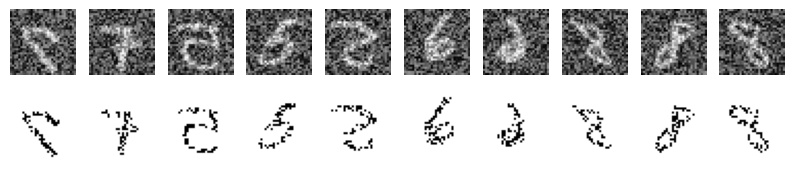

In [14]:
nRow = 2 
nCol = batch_size 
plt.figure(figsize=(nCol, nRow))
for i in range(batch_size):
    plt.subplot(nRow, nCol, nCol * 0 + i + 1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 1 + i + 1)
    plt.imshow(pred[i].squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()

## quantitative evaluation of the trained model on the testing dataset

In [15]:
eval    = MyEval(metric='iou')
result  = MyResult()

In [16]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='test') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)
threshold   = 0.5
eval.metric_reset()
for step, (image, mask) in enumerate(tqdm(dataloader)):
    pred = model(image)
    pred = (pred > threshold).float()  # Binarize the prediction
    eval.metric_update(pred, mask)

metric_value = eval.metric_compute()
result.add_result('test', metric_value)
print(f'IoU (test): {metric_value}')

0it [00:00, ?it/s]

IoU (test): 0.0


/Users/daehyeon/Documents/대학 자료/3-2/neural_network/neural_network_venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric BinaryJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


## plot the segmentation results on the testing dataset

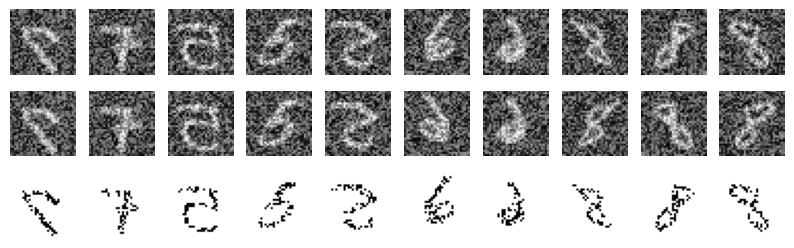

In [17]:
nRow = 3 
nCol = batch_size 
plt.figure(figsize=(nCol, nRow))
for i in range(batch_size):
    plt.subplot(nRow, nCol, nCol * 0 + i + 1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 1 + i + 1)
    plt.imshow(mask[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 2 + i + 1)
    plt.imshow(pred[i].squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()